In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pipeline as p
import assess_clf_models as acm

%load_ext autoreload
%autoreload 2

/Users/kendra/anaconda3/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.pipeline import make_pipeline

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, roc_curve, auc

from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [5]:
from matplotlib import rcParams

# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']

# plt.style.use('/Users/kendra/.matplotlib/kf_fig.mplstyle')
plt.style.use('/Users/kendra/.matplotlib/base_style.mplstyle')
# plt.style.use('ggplot')

In [6]:
seed = 19

#### Load & Prep data

In [6]:
# Data without sub-types (larger)
X_train = p.open_pkl('Data/X_train_unprocessed.pkl')
y_train = p.open_pkl('Data/y_train_unprocessed.pkl')

In [7]:
# Data with sub-types (fewer # rows)
X_train_sub = p.open_pkl('Data/X_train_unproc_with_sub.pkl')
y_train_sub = p.open_pkl('Data/y_train_unproc_with_sub.pkl')

In [8]:
X_train_sub_wo = X_train_sub.drop(columns=['BRST_SUB'])

In [9]:
preproc1 = p.open_pkl('Data/preprocess_wo_sub.pkl')
preproc2 = p.open_pkl('Data/preprocess_with_sub.pkl')

### Generate average ROC curve for each model:

In [10]:
log_reg = LogisticRegression(solver='liblinear')
grad_boost = GradientBoostingClassifier()
ada = AdaBoostClassifier()
rand_for = RandomForestClassifier(n_estimators=10)
nb = GaussianNB()

In [20]:
mod1 = acm.get_avg_roc_curve(preproc1, grad_boost, X_train, y_train)
mod2 = acm.get_avg_roc_curve(preproc1, log_reg, X_train, y_train)

mod3 = acm.get_avg_roc_curve(preproc2, grad_boost, X_train_sub, y_train_sub)
mod4 = acm.get_avg_roc_curve(preproc1, grad_boost, X_train_sub_wo, y_train_sub)

### Plot them all:

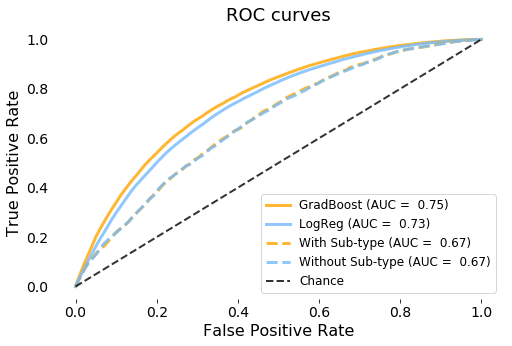

In [21]:
mod_list = {'GradBoost': mod1, 'LogReg': mod2, 'With Sub-type': mod3, 'Without Sub-type': mod4 } #, 
color_list = ['orange', 'xkcd:sky blue','orange', 'xkcd:sky blue']
lstyle_list = ['-','-','--','--']
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

i = 0
for name, model in mod_list.items():

    plt.plot(model[0], model[1],
             label=f"{name} (AUC = {model[2]: .2f})",
             color=color_list[i], linestyle=lstyle_list[i],
             lw=3, alpha=.8)
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(loc="lower right", fontsize=12)
plt.title('ROC curves', fontsize=18)
plt.savefig('Figures/ROC_curves02.png', dpi=300, transparent=False)

### Negative Predictive Value

https://wikimedia.org/api/rest_v1/media/math/render/svg/25ee592b2b1e1e21749b391cca348d32c545ea67

NPV = TN / (TN + FN)

In [27]:
cut = np.linspace(0,1,100)

In [29]:
nmod1 = acm.get_avg_npv_curve(preproc1, grad_boost, X_train, y_train)
nmod2 = acm.get_avg_npv_curve(preproc1, log_reg, X_train, y_train)
nmod3 = acm.get_avg_npv_curve(preproc1, nb, X_train, y_train)
nmod4 = acm.get_avg_npv_curve(preproc2, ada, X_train_sub, y_train_sub)

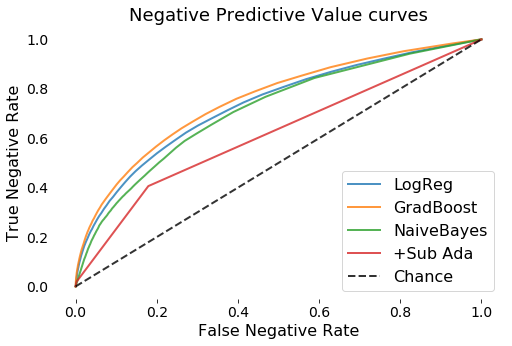

In [30]:
nmod_list = {'LogReg': nmod2, 'GradBoost': nmod1, 'NaiveBayes':nmod3, '+Sub Ada':nmod4}

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

i = 0
for name, model in nmod_list.items():

    plt.plot(model[0], model[1],
             label=f"{name}",
#              color=color_list[i],
             lw=2, alpha=.8)
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Negative Rate', fontsize=16)
plt.ylabel('True Negative Rate', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(loc="lower right", fontsize=16)
plt.title('Negative Predictive Value curves', fontsize=18)
plt.savefig('Figures/NPV_curves01.png', dpi=300, transparent=False)

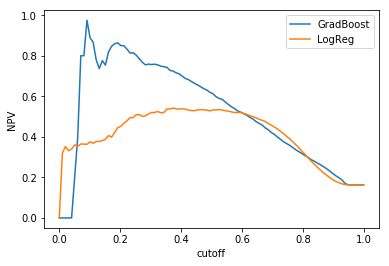

In [134]:
plt.plot(cut,nmod1[3], label='GradBoost')
plt.plot(cut,nmod2[3], label='LogReg')
plt.xlabel('cutoff')
plt.legend()
plt.ylabel('NPV');

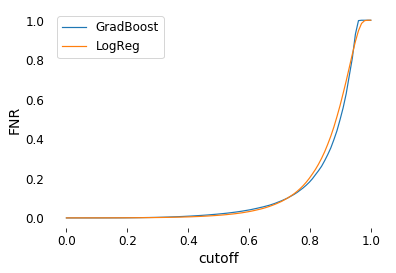

In [33]:
plt.plot(cut,nmod1[0], label='GradBoost')
plt.plot(cut,nmod2[0], label='LogReg')
plt.xlabel('cutoff')
plt.legend()
plt.ylabel('FNR');

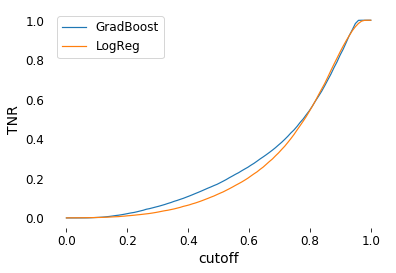

In [32]:
plt.plot(cut,nmod1[1], label='GradBoost')
plt.plot(cut,nmod2[1], label='LogReg')
plt.xlabel('cutoff')
plt.legend()
plt.ylabel('TNR');

**Confusion Matrix**

In [12]:
gb_cm = p.conf_mat_avg_cv(preproc1, grad_boost, X_train, y_train)

In [13]:
gb_cm / (len(X_train)/5)

TN    0.028234
FN    0.016683
FP    0.134711
TP    0.820372
dtype: float64